# Determining the cost of cars

The service for the sale of cars with “not bit, not painted” is developing an application to attract new customers.In it you can quickly find out the market value of your car.At your disposal historical data: technical characteristics, configuration and prices of cars.You need to build a model to determine the cost.

The customer is important:

- quality of prediction;
- the speed of prediction;
- The time of training.

Instructions for the implementation of the project

To strengthen the study, do not limit yourself to gradient boosting.Try simpler models - sometimes they work better.These rare cases are easy to skip if only boosting is always used.
Experiment and compare the characteristics of models: training time, prediction time, accuracy of the result.

Main steps:

- Download the data, the path to the file: `/datasets/autos.csv`
- Study the data.Fill in the missed values ​​and process anomalies in column.If there are non -informative ones among the signs, remove them
- Prepare samples for teaching models
- Teach different models, one of which is LightGBM, at least one - not boosting.For each model, try different hyperparameters
- Analyze the time of training, the time of prediction and the quality of the models
- Based on the customer’s criteria, choose the best model, check its quality in a test sample

Notes:
- To assess the quality of models, use RMSE metric
- the value of the RMSE metric should be less than 2500
- Start the LightGBM library yourself and build a gradient boosting model with its means
- The time of execution of the Jupyter Notebook code can be obtained by a special team.Find it
- The model of gradient boosting can study for a long time, so change her only two or three parameters
- If Jupyter Notebook stops working, delete extra variables `Del`

Del features_train

Data description
- Data are in the file [/datasets/autos.csv ,(Https://code.s3.yandex.net/datasets/autos.csv "Code.s3.S3.yandex.NET/DATASTS/ATOS.CSV")

Signs
- `DATECRAWLED` - Date of downloading of the questionnaire from the base
- `vehicleType` - type of car body
- `registrationyear` - year of registration of the car
- `gearbox` - type of gearbox
- `Power` - power (p.)
- `Model` - car model
- `kilometer` - mileage (km)
- `registrationMonth` - Month of car registration
- `fueltype` - fuel type
- `Brand` - car brand
- `repaired` - there was a car in repair or not
- `DATECREATED` - Date of creation of a questionnaire
- `numberofpictures` - number of car photos
- `postalcode` - postal index of the questionnaire (user)
- `Lastseen` - Date of the last user activity

Target sign
- `price` - price (euro)

## Data Preparation

In [3]:
# отключим предупреждающие уведомления
import warnings
warnings.filterwarnings('ignore')

# Добавим основные библиотеки
import pandas as pd
import numpy as np
import os.path
import math

# Добавим библиотеки для отрисовки графиков
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# добавим необходимые библиотеки для построения моделей
from sklearn.model_selection import train_test_split
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Сделаем небольшие настройки pandas для комфортного отображения проекта
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [4]:
# Импортируем датасеты методом try/except и установим индексом столбец date
try:
    path_df = os.path.join('datasets/autos.csv')
    df = pd.read_csv(path_df)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
# Функция для вывода первичной информации по датасету
def first_view(data):
    title_lenght = 79
    title_one = 'Обзор данных первых и последних пяти строк'
    print('~' * int((title_lenght - len(title_one)) / 2), title_one, '~' * (title_lenght - len(title_one) - int((title_lenght - len(title_one)) / 2)))
    display(data.head(5))
    display(data.tail(5))
    print()
    title_two = 'Основная описательная статистика'
    print('~' * int((title_lenght - len(title_two)) / 2), title_two, '~' * (title_lenght - len(title_two) - int((title_lenght - len(title_two)) / 2)))
    display(data.describe())
    print()
    title_three = 'Тип данных' 
    print('~' * int((title_lenght - len(title_three)) / 2), title_three, '~' * (title_lenght - len(title_three) - int((title_lenght - len(title_three)) / 2)))
    data.info()
    print()
    title_four = 'Подсчёт пропусков'
    print('~' * int((title_lenght - len(title_four)) / 2), title_four, '~' * (title_lenght - len(title_four) - int((title_lenght - len(title_four)) / 2)))
    all_nulls = 0
    for col in data.columns:
       if data[col].isna().sum() > 0:
            all_nulls += 1
            print(data[col].isna().sum(), 'пропущенных значений в колонке', col, 'это', round(data[col].isna().mean() * 100,), '%')
    if all_nulls == 0:
        print('В датафрейме пропуски отсутствуют')
    print()
    title_five = 'Явные дубликаты'
    print('~' * int((title_lenght - len(title_five)) / 2), title_five, '~' * (title_lenght - len(title_five) - int((title_lenght - len(title_five)) / 2)))
    if data.duplicated().sum() > 0:
        print('Количество явных дубликатов - ', data.duplicated().sum())
    else:
        print('Явные дубликаты в датасете отсутствуют')
    print()
    title_six = 'Просмотр гистограмм датафрейма'
    print('~' * int((title_lenght - len(title_six)) / 2), title_six, '~' * (title_lenght - len(title_six) - int((title_lenght - len(title_six)) / 2)))
    data.hist(bins=50, figsize = (8, 8));

~~~~~~~~~~~~~~~~~~ Обзор данных первых и последних пяти строк ~~~~~~~~~~~~~~~~~~~


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21



~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.00,354369.00,354369.00,354369.00,354369.00,354369.00,354369.00
mean,4416.66,2004.23,110.09,128211.17,5.71,0.00,50508.69
std,4514.16,90.23,189.85,37905.34,3.73,0.00,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.00,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,0.00,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,0.00,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,0.00,71083.00
max,20000.00,9999.00,20000.00,150000.00,12.00,0.00,99998.00



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-nul

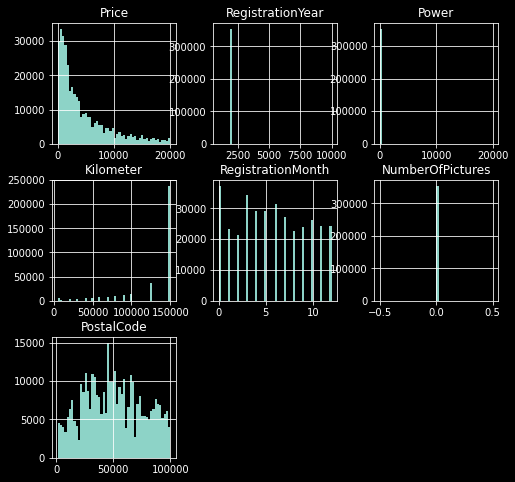

In [6]:
first_view(df)

Conclusion from the initial data inspection:

- There are gaps
- There are duplicates
- there are anamal values ​​in the parameters of the year of registration and engine power
- the number of images is a completely empty column in which all values ​​are zero
- There are zero values ​​of the price in the target feature
- In the column, the month of registration is zero value and this is not the beginning of the reference from zero, because there is 12

We will analyze the data in more detail, preparing the data in the course of the case

To begin with, rename the columns, group them in meaning for convenience and immediately get rid of the excess (an empty column with zero number of pictures everywhere)

In [7]:
df.columns.tolist()

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'Repaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen']

In [8]:
df = df.rename(columns={
    'Price':'price',
    'VehicleType':'vehicle_type',
    'RegistrationYear':'reg_year',
    'Gearbox':'gearbox',
    'Power':'power',
    'Model':'model',
    'Kilometer':'km',
    'RegistrationMonth':'reg_month',
    'FuelType':'fuel_type',
    'Brand':'brand',
    'Repaired':'repaired',
    'PostalCode':'postal_code',
    'DateCreated':'date_created',
    'DateCrawled':'date_crawled',
    'LastSeen':'date_last_seen'
})

df.columns.tolist() # проверяем

['date_crawled',
 'price',
 'vehicle_type',
 'reg_year',
 'gearbox',
 'power',
 'model',
 'km',
 'reg_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'NumberOfPictures',
 'postal_code',
 'date_last_seen']

In [9]:
df = df[['date_created',
         'date_crawled',
         'date_last_seen',
         'postal_code',
         'vehicle_type',
         'fuel_type',
         'brand',
         'model',
         'reg_year',
         'reg_month',
         'km',
         'gearbox',
         'power',
         'repaired',
         'price'
         ]]

Get rid of duplicates

In [10]:
df.drop_duplicates(inplace=True, ignore_index=True)

We will get rid of anomalies in a column with a CAR COMP COMP

In [11]:
shape_before = df.shape[0]
df = df.loc[(df['reg_year'] > 1900) & (df['reg_year'] < 2016)]
print(f'удалено строк: {shape_before - df.shape[0]}')

удалено строк: 24195


Get rid of anomalies in a column with engine power

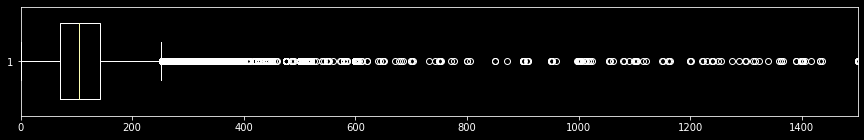

In [12]:
plt.figure(figsize=(15,2))
plt.boxplot(df['power'], vert=False, widths=0.7)
plt.xlim(0,1500)
plt.show();

There are very large emissions.Of course, there are cars with such powerful engines, but rather this is anomalies in the data.Let's look at these emissions

In [13]:
df.loc[df['power'] > 300].sort_values(by='power', ascending=False)

,date_created,date_crawled,date_last_seen,postal_code,vehicle_type,fuel_type,brand,model,reg_year,reg_month,km,gearbox,power,repaired,price
219583,2016-03-09 00:00:00,2016-03-09 15:43:53,2016-03-30 08:47:08,19406,coupe,petrol,mercedes_benz,clk,1999,1,150000,auto,20000,no,4300
299177,2016-03-09 00:00:00,2016-03-09 08:53:11,2016-04-07 11:44:34,21129,wagon,NaN,bmw,5er,1997,1,150000,manual,19312,no,1500
114106,2016-04-03 00:00:00,2016-04-03 07:36:21,2016-04-07 10:16:10,45964,sedan,gasoline,bmw,1er,2006,0,125000,manual,19211,NaN,9999
132485,2016-03-25 00:00:00,2016-03-25 14:55:49,2016-03-30 05:16:18,59556,wagon,NaN,bmw,5er,2001,5,150000,manual,19208,yes,2100
63986,2016-03-28 00:00:00,2016-03-28 11:49:56,2016-04-06 14:17:21,86641,sedan,petrol,opel,omega,2001,6,150000,auto,17932,NaN,3250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128896,2016-03-19 00:00:00,2016-03-19 23:36:35,2016-04-02 05:15:39,25764,other,petrol,daihatsu,cuore,1998,4,125000,manual,301,no,1000
130007,2016-03-06 00:00:00,2016-03-06 10:49:30,2016-03-14 19:15:18,46483,coupe,petrol,nissan,NaN,2007,8,125000,manual,301,no,13900
224430,2016-04-04 00:00:00,2016-04-04 14:48:57,2016-04-06 16:17:21,84036,coupe,petrol,audi,NaN,1998,0,125000,manual,301,no,5990
11197,2016-03-26 00:00:00,2016-03-26 22:51:57,2016-04-06 18:48:25,10829,coupe,petrol,nissan,other,2005,5,150000,manual,301,NaN,11000


More often these are serial cars (Audi, Opel, BMW) and there is a high probability that the power is extremely high, but really powerful cars like Porshe come across.It is difficult to draw a line between anomalies and just emissions, you will have to either leave part of the anomalies, but save useful data, or cut off useful data, but get rid of anomalies.We will leave part of the anomalies and get rid of only obvious anomalies in order not to lose useful data in the segment of powerful cars.We also remove cars with a power to zero L.S.

In [14]:
shape_before = df.shape[0]
df = df.loc[(df['power'] < 500) & (df['power'] != 0)]
print(f'удалено строк: {shape_before - df.shape[0]}')

удалено строк: 34081


Remove the anomalies in the target sign

In [15]:
shape_before = df.shape[0]
df = df.loc[df['price'] != 0]
print(f'удалено строк: {shape_before - df.shape[0]}')

удалено строк: 5996


Passes fill in the field `unknown` becauseWe do not know real information from missed cells and if we try to fill them out with data, we will rather make more distortions, it is better to let the model predicts the price on the basis that the data is missing

In [16]:
df.fillna('unknown', inplace=True)

Let's see what is with the dates and if we need them

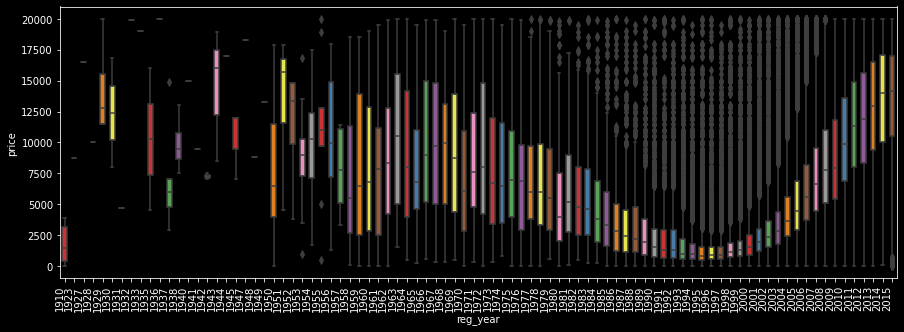

In [17]:
# посмотрим на зависимость цены от года регистрации авто
plt.figure(figsize=(15,5))
sns.boxplot(x='reg_year', y='price', data=df, palette="Set1", width=0.5)
plt.xticks(rotation=90, ha='right')
plt.show()

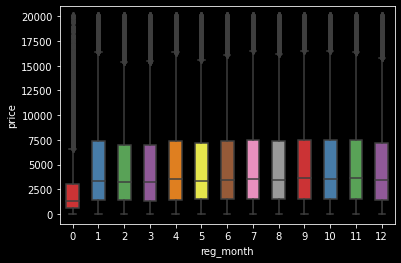

In [18]:
# посмотрим на зависимость цены от месяца регистрации авто
sns.boxplot(x='reg_month', y='price', data=df, palette="Set1", width=0.5)
plt.show()

In [19]:
# сконвертируем столбцы с датой в формат datetime64
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
df['date_last_seen'] = pd.to_datetime(df['date_last_seen'], format='%Y-%m-%dT%H:%M:%S')

In [20]:
# посмотрим какие уникальные значения года есть в столбцах
print(df['date_created'].dt.year.unique())
print(df['date_crawled'].dt.year.unique())
print(df['date_last_seen'].dt.year.unique())

[2016 2015]
[2016]
[2016]


In [21]:
# посмотрим на соотношение количества записей по разным годам в столбце даты создания
df['date_created'].dt.year.value_counts()

2016    290069
2015        24
Name: date_created, dtype: int64

In [22]:
# создадим отдельные столбцы с месяцами по каждому из столбцов
df['month_created'] = df['date_created'].dt.month
df['month_crawled'] = df['date_crawled'].dt.month
df['month_last_seen'] = df['date_last_seen'].dt.month

# создадим мини датасет со сводной информацией по средней цене за месяца
month = pd.DataFrame({'created': df.groupby('month_created')['price'].mean(),
                     'crawled': df.groupby('month_crawled')['price'].mean(),
                     'last seen': df.groupby('month_last_seen')['price'].mean()})

# посмотрим на эти данные
month

,created,crawled,last seen
1,8341.88,NaN,NaN
2,6367.48,NaN,NaN
3,4864.26,4866.11,4095.27
4,5086.82,5092.07,5490.21
8,9725.00,NaN,NaN
9,3566.67,NaN,NaN
11,7753.89,NaN,NaN
12,7249.89,NaN,NaN


In [23]:
# посмотрим на количество записей по месяцам в столбце даты создания
df.groupby('month_created')['price'].count()

month_created
1         57
2        351
3     242669
4      46993
8          2
9          3
11         9
12         9
Name: price, dtype: int64

In [24]:
# повторим для других столбцов
df.groupby('month_crawled')['price'].count()

month_crawled
3    242735
4     47358
Name: price, dtype: int64

In [25]:
df.groupby('month_last_seen')['price'].count()

month_last_seen
3    122118
4    167975
Name: price, dtype: int64

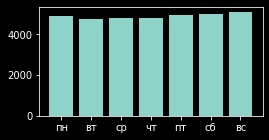

In [26]:
# создадим столбцы  по неделям
df['weekday_created'] = df['date_created'].dt.weekday
df['weekday_crawled'] = df['date_crawled'].dt.weekday
df['weekday_last_seen'] = df['date_last_seen'].dt.weekday

# создадим сводную таблицу со средними ценами за неделю
week = pd.DataFrame({'created': df.groupby('weekday_created')['price'].mean(),
                     'crawled': df.groupby('weekday_crawled')['price'].mean(),
                     'last seen': df.groupby('weekday_last_seen')['price'].mean()})

# выведем эти данные в виде таблиц
bars = ('пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс')
y_pos = np.arange(len(bars))

plt.figure(figsize=(4,2))
plt.bar(y_pos, week['created'])
plt.xticks(y_pos, bars)
plt.show()

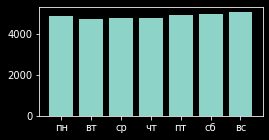

In [27]:
plt.figure(figsize=(4,2))
plt.bar(y_pos, week['crawled'])
plt.xticks(y_pos, bars)
plt.show()

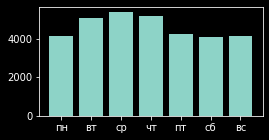

In [28]:
plt.figure(figsize=(4,2))
plt.bar(y_pos, week['last seen'])
plt.xticks(y_pos, bars)
plt.show()

Year of registration of cars

Prices for cars 20 or less, falls than the car is older than the car, after 20 years, prices on the contrary begin to grow, the retro car segment begins.Here you can create an additional class for segmentation on retro/new.

A month of registration of a car

In all 12 months, there is no significant impact on the price, moreover, there is an incomprehensible zero month that just affects the price.Perhaps people selling an old and cheap car do not bother to enter a month correctly.Be that as it may, this column only bothers us, get rid of it.


columns with the dates of creation/registration/unloading

Everywhere there is one in all three columns, with the exception of several records of not 2016, but one column that can be dedicated to.

Almost all notes occur for 3 and 4 months in all three columns with dates, this is strange, the reason for this is not clear, but using such data dubious idea.

The days of the week from the two columns are almost never flooded, there is a slight inflinking for the price in the column that is responsible for the last appearance of the user on the site.This is strange, the price of a car is unlikely to depend on when the person was last on the site.

It looks so that these columns can simply remove and do not load the model with them, it will be learned without them faster and these data will not enter errors, so the quality will be better without them.

In [29]:
df = df.drop(['date_created','date_crawled','date_last_seen',
              'weekday_created','weekday_crawled','weekday_last_seen',
              'month_created', 'month_crawled', 'month_last_seen',
              'reg_month'
              ], axis=1)

In [30]:
def retro_classifier(year):
    if year < 1996:
        return 1
    else:
        return 0

df['retro'] = df['reg_year'].apply(retro_classifier)

## Model training

We will divide the dataset into samples

In [31]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train_n_valid, X_test, y_train_n_valid, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1337)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_n_valid, y_train_n_valid, test_size=0.25, random_state=1337)

print('Размер тренировочной выборки:')
print(f'признаки {X_train.shape};')
print(f'целевой признак {y_train.shape}')
print(f'это {round((y_train.count() / y.count()) * 100)}% от датасета')
print()
print('Размер валидационной выборки:')
print(f'признаки {X_valid.shape};')
print(f'целевой признак {y_valid.shape}')
print(f'это {round((y_valid.count() / y.count()) * 100)}% от датасета')
print()
print('Размер тестовой выборки:')
print(f'признаки {X_test.shape};')
print(f'целевой признак {y_test.shape}')
print(f'это {round((y_test.count() / y.count()) * 100)}% от датасета')

Размер тренировочной выборки:
признаки (174055, 11);
целевой признак (174055,)
это 60% от датасета

Размер валидационной выборки:
признаки (58019, 11);
целевой признак (58019,)
это 20% от датасета

Размер тестовой выборки:
признаки (58019, 11);
целевой признак (58019,)
это 20% от датасета


We encode parameters by `binaryencoder`

In [32]:
# обозначаем названия столбцов для кодировки списком
x_to_enc = ['vehicle_type','fuel_type','brand','model','gearbox','repaired']

# выбираем кодировщик
bn = BinaryEncoder()

# сбрасываем индексы в выборка для корректного объединения кодированных данных с остальной таблицей в дальнейшем
X_train.reset_index(inplace=True)
X_train.drop(['index'], axis=1, inplace=True)
X_valid.reset_index(inplace=True)
X_valid.drop(['index'], axis=1, inplace=True)
X_test.reset_index(inplace=True)
X_test.drop(['index'], axis=1, inplace=True)

# кодируем выбранные столбцы по списку названий в выборках обучая кодировщик на них же
coded_X_train = bn.fit_transform(X_train[x_to_enc].values)
coded_X_valid = bn.transform(X_valid[x_to_enc].values)
coded_X_test = bn.transform(X_test[x_to_enc].values)

# удаляем из выборок оригинальные, не закодированные столбцы
X_train = X_train.drop(x_to_enc, axis=1)
X_valid = X_valid.drop(x_to_enc, axis=1)
X_test = X_test.drop(x_to_enc, axis=1)

# добавляем в выборки закодированные столбцы
X_train = pd.concat([X_train, coded_X_train], axis=1)
X_valid = pd.concat([X_valid, coded_X_valid], axis=1)
X_test = pd.concat([X_test, coded_X_test], axis=1)

Create a variable for ross validation

In [33]:
cv = KFold(n_splits=5, random_state=1337, shuffle=True)

## RandomForestregressor Model

Find good parameters using `RandomizedSearchcv`.To do this, we will take a validation sample, since it is less and the process will pass faster.

In [34]:
rf_model = RandomForestRegressor()

rf_params = {'random_state': [1337],
             'n_estimators': range(100, 1001, 100),
             'max_depth': [1,4,8,12,16,20],
             'min_samples_split' : [2,6,10,16],
             'min_samples_leaf' : [1,2,4,8,16]
             }

rf_rndsch = RandomizedSearchCV(rf_model,
                               param_distributions = rf_params,
                               n_iter = 20,
                               scoring='neg_root_mean_squared_error',
                               error_score='raise',
                               cv = cv,
                               random_state = 1337,
                               n_jobs = -1
                               )

rf_rndsch.fit(X_valid, y_valid)

rf_rmse = abs(rf_rndsch.best_score_)

print('значение RMSE модели случайного леса:')
print(rf_rmse)
print('при следующих параметрах:')
print(rf_rndsch.best_params_)

значение RMSE модели случайного леса:
1732.9619596967764
при следующих параметрах:
{'random_state': 1337, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 16}


The parameters found using RandomizedSearchcv:

The value of the RMSE model of random forest:
1732.9619596967764
At the following parameters:
{'random_state': 1337, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 16}

The overkill of the parameters is carried out among this space of options:

{'random_state': [1337],
'n_estimators': Range (100, 1001, 100),
'max_depth': [1,4,8,12,16,20],
'min_samples_split': [2,6,10,16],
'min_samples_leaf': [1,2,4,8,16]
}

Time spent in search of 21 minutes

We use the found parameters for teaching the model already on the training sample and check on the validation

In [35]:
rf_model = RandomForestRegressor(random_state=1337,
                              n_estimators=200,
                              max_depth=16,
                              min_samples_split=2,
                              min_samples_leaf=2
                              )

In [36]:
%%time
rf_model.fit(X_train, y_train)

CPU times: user 2min 44s, sys: 1e+03 ms, total: 2min 45s
Wall time: 2min 45s


RandomForestRegressor(max_depth=16, min_samples_leaf=2, n_estimators=200,
                      random_state=1337)

In [37]:
%%time
predict_valid = rf_model.predict(X_valid)

CPU times: user 3.08 s, sys: 16 ms, total: 3.1 s
Wall time: 3.11 s


In [38]:
rf_rmse = mean_squared_error(predict_valid, y_valid)**0.5
print('RMSE модели случайного леса:', round(rf_rmse, 2))

RMSE модели случайного леса: 1595.56


## Lightgbm Model

To begin with, we will enter the parameters for the gradient boosting model with our hands to understand what we are from

In [50]:
%%time

gb1_model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='regression',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=1337,
    silent=True
    )

gb1_rmse = cross_val_score(gb1_model, X_valid, y_valid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print(f'RMSE модели градиентного бустинга LightGBM {round(abs(np.mean(gb1_rmse)), 2)}')

RMSE модели градиентного бустинга LightGBM 1704.72
CPU times: user 12.7 s, sys: 68.8 ms, total: 12.8 s
Wall time: 12.8 s


Find the parameters that will improve our quality using `RandomizedSearchcv`

In [40]:
gbrs_model = LGBMRegressor(
                    objective='regression',
                    min_split_gain=0.0,
                    min_child_samples=20,
                    subsample=1.0,
                    subsample_freq=0,
                    colsample_bytree=1.0,
                    reg_alpha=0.0,
                    reg_lambda=0.0,
                    seed=1337
                )

gb_parameters = {'num_leaves': [21, 31, 41, 60],
                'max_depth': [-1, 0, 1, 16, 32],
                'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
                'n_estimators': [100, 200, 400]
                }
                
gb_rndsch = RandomizedSearchCV(gbrs_model, 
                               param_distributions = gb_parameters,
                               n_iter = 300, 
                               scoring='neg_root_mean_squared_error', 
                               error_score='raise', 
                               cv = cv,
                               random_state = 1337,
                               n_jobs = -1
                               )

gb_rndsch.fit(X_valid, y_valid)

gb_rndsch_rmse = abs(gb_rndsch.best_score_)

print('значение RMSE LightGBM модели градиентного бустинга:')
print(gb_rndsch_rmse)
print('при следующих параметрах:')
print(gb_rndsch.best_params_)

значение RMSE LightGBM модели градиентного бустинга:
1626.133687051163
при следующих параметрах:
{'num_leaves': 60, 'n_estimators': 400, 'max_depth': 16, 'learning_rate': 0.1}


The parameters found using RandomizedSearchcv:

RMSE LightGBM value of gradient boosts:
1626.133687051163
At the following parameters:
{'num_leaves': 60, 'n_estimators': 400, 'max_depth': 16, 'Learning_Rate': 0.1}

The overkill of the parameters is carried out among this space of options:

{'num_leaves': [21, 31, 41, 60],
'max_depth': [-1, 0, 1, 16, 32],
'Learning_Rate': [0.01, 0.1, 0.2, 0.3, 0.4],
'n_estimators': [100, 200, 400]
}

Time spent in search

Check the found parameters on the validation sample and compare the results

In [52]:
%%time

gb2_model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=60,
    max_depth=16,
    learning_rate=0.1,
    n_estimators=400,
    objective='regression',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=1337,
    silent=True
    )

gb2_rmse = cross_val_score(gb2_model, X_valid, y_valid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print(f'RMSE модели градиентного бустинга LightGBM {round(abs(np.mean(gb2_rmse)), 2)}')

RMSE модели градиентного бустинга LightGBM 1626.13
CPU times: user 59.2 s, sys: 480 ms, total: 59.6 s
Wall time: 60 s


The quality has improved from 1704.72 to 1626.13, while the time spent on teaching the model on the cross -country cross and the metric calculation increased from 12.8 S to 59.6 s.
As we see, the growth as a completely proportional time spent, the speed of training has decreased significantly, and since the speed of training is also important to us, such a mural of quality is not such a slowdown in the process.In the task, we needed to achieve the quality of RMSE no more than 2500, and we achieve these goals with the initially taken parameters, but with a much ray time of training.


We will train the model in the training sample

In [51]:
gb_model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective='regression',
    min_split_gain=0.0,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=1337,
    silent=True
    )

In [43]:
%%time
gb_model.fit(X_train, y_train)

CPU times: user 5.34 s, sys: 37.4 ms, total: 5.38 s
Wall time: 5.39 s


LGBMRegressor(objective='regression', random_state=1337, silent=True)

In [44]:
%%time
gb_predict_valid = gb_model.predict(X_valid)

CPU times: user 460 ms, sys: 0 ns, total: 460 ms
Wall time: 411 ms


In [45]:
gb_rmse = mean_squared_error(gb_predict_valid, y_valid)**0.5
print('RMSE модели градиентного бустинга:', round(gb_rmse, 2))

RMSE модели градиентного бустинга: 1673.48


## Analysis of models

In [54]:
analys_df = pd.DataFrame({'Model': ['RandomForestRegressor Model', 'LightGBM Model'],
                          'RMSE': [rf_rmse, gb_rmse],
                          'CPU time: обучение': ['2min 45s', '5.38 s'],
                          'CPU time: предсказание': ['3.1 s', '460 ms']
                          })
analys_df

,Model,RMSE,CPU time: обучение,CPU time: предсказание
0,RandomForestRegressor Model,1595.56,2min 45s,3.1 s
1,LightGBM Model,1673.48,5.38 s,460 ms


Compared to the model of random forest, the model of gradient boosting shows a huge increase in the speed of training, while demonstrating good quality.Unlike RandomForest, gradient boosting is not studying in minutes, but in seconds.The rate of prediction also increases by double and is calculated in a fraction of a second.

When choosing the parameters, you can achieve possible qualities better than that of the model of a random forest, while the speed will still be better, but becauseThe task is to find the balance between quality and speed, it was decided to leave the quality such a little worse than that of a random forest, for the sake of speed of work, which increases significantly on such parameters

Check the model on test data

In [47]:
%%time
gb_predict_test = gb_model.predict(X_test)

CPU times: user 479 ms, sys: 0 ns, total: 479 ms
Wall time: 381 ms


In [48]:
final_rmse = mean_squared_error(gb_predict_test, y_test)**0.5
print('RMSE модели:', round(final_rmse, 2))

RMSE модели: 1669.03


Conclusion

In the course of work, data for teaching models were studied and prepared.A comparative analysis of models of random forest and gradient boosting was carried out.
The gradient boosting model showed itself better in all respects both in quality and in the speed of prediction and especially in the speed of training.

The final RMSE model in the test sample is 1669.03
The speed of training was 5.38 s
Prediction speed 479 ms